In [258]:
import pandas as pd
import os
import librosa
import os
from skimage import io
import torch
import torchvision
from torch.utils.data import Dataset
import math

## Reconstructing File Paths

file_path = 'Datasets/LibriSpeech/train-clean-100.index.csv'

df = pd.read_csv(file_path)

df.columns

df.head()

df.shape


df.filepath[1]

df.filepath[1][0:38]

mine = '/home/amonajemi/amonajemi/Datasets'

df['filepath'] = df['filepath'].str[37:]

df['filepath'] = mine + df['filepath']

df['filepath'].head()

from torch.utils.data import Dataset

df.head()

df = df[df.seconds > 5.0]

# Class Creation

class LibriSpeechData(Dataset):
    def __init__(self,df,transform = None, sampling_rate = 16000, offset=1.0, duration=5.0):
        self.duration = duration
        self.df = df
        self.audio = self.df['filepath']
        self.identities=self.df['id']
        self.transform = transform
        self.sampling_rate = sampling_rate
        if self.transform is None:
            self.transform = torch.from_numpy # Call it as an object! Now transform is defined so 
                                                # we cn iterate through the batches. 

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        audio = self.audio[index]
        self.seconds = self.df['seconds'][index]
        self.offset = random.uniform(0,self.seconds - self.duration)
        y,  sr  = librosa.load(audio, sr=self.sampling_rate, offset=self.offset, duration=self.duration)
        # The y is the one-dimensional np.array
        #that is the amplitude of the waveform at sample t
        
        #the sr is the number of samples per second of a
        #time series.
    
        time_series = self.transform(y)
        
        return time_series, torch.tensor(self.identities[index])        

df.index # Our filtering of the dataset kept the original index. This is why you see 28437 here but the
#overall length of indexes is indeed 26504 

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

def waveplot(y, r):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(y, sr=r)


def spectrogram_plot(y):
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=r, x_axis='time', y_axis='log')
    
def energy_plot(a, hop_length = 256, frame_length = 2048):
    energy = np.array([
        sum(abs(a.numpy()[i:i+frame_length]**2))
        for i in range(0, len(a.numpy()), hop_length)])
    return plt.plot(energy / energy.max()), a.min(),a.max()
    








In [265]:
dataset = LibriSpeechData(df)

In [269]:
filename = random.choice(df.index)
a, b = dataset[filename]
print(a)

tensor([ 6.5918e-03,  6.7444e-03,  6.5918e-03,  ..., -7.0190e-04,
        -4.5776e-04, -6.1035e-05])


In [ ]:
## Energy Detection 

def energy_values(a, hop_length = 256, frame_length = 2048):
    energy = np.array([
        sum(abs(a.numpy()[i:i+frame_length]**2))
        for i in range(0, len(a.numpy()), hop_length)])
    return energy

In [270]:
## Voices Dataset

Voices = pd.read_csv("/home/amonajemi/amonajemi/Datasets/VOiCES/VOiCES-room-1.index.csv")

Voices.columns

Voices['filepath'][40000]

Voices['filepath'][1][22:]

file_e = '/home/amonajemi/amonajemi/Datasets/VOiCES/Volumes/'

Voices['filepath'] = Voices['filepath'].str[22:]

Voices['filepath'] = file_e + Voices['filepath']
    

Voices = Voices[~Voices.filepath.str.contains("tele")]

len(Voices)

Voices.index = range(0,len(Voices))

Voices = Voices[(Voices.filepath.str.contains("sp_3549") & Voices.filepath.str.contains("none"))|(Voices.filepath.str.contains("sp_6241") & Voices.filepath.str.contains("none")) | (Voices.filepath.str.contains("sp_1212") & Voices.filepath.str.contains("musi")) | (Voices.filepath.str.contains("sp_6241") & Voices.filepath.str.contains("musi"))]

Voices.index = range(0,len(Voices))

filename = random.choice(Voices['filepath'])
y , sr = librosa.load(filename)


class VoicesDataSet(LibriSpeechData):
    pass
    

data = VoicesDataSet(Voices)
a, b = data[random.choice(Voices.index)]

In [20]:
def energy_values(a, hop_length = 256, frame_length = 2048):
    energy = np.array([
        sum(abs(a[i:i+frame_length]**2))
        for i in range(0, len(a), hop_length)])
    return energy

get_energy = energy_values

In [23]:
get_energy = energy_values

In [25]:
import IPython.display as ipd

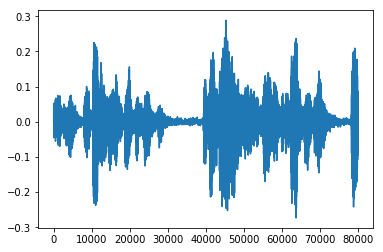

In [1308]:
t = VoicesDataSet(Voices)[random.choice(Voices.index)][0].numpy()
plt.plot(t)

In [1900]:
## Fade In / Fade Out
import statistics
def fading_in(length):
    fading_in =np.linspace(0, 1, length)
    #fading_in[int(length*.50):] = 1
    return fading_in

def fading_out(length):
    fading_out = np.linspace(0,1, length)[::-1]
    #fading_out[:int(length * .50)] = 1
    return fading_out



# VAD

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    greatest = 0
    start = 0       # For Voices change this to the max interval again like below
    end = 0
    for interval in ranges:
        diff = interval[1] - interval[0]
        if diff > greatest:
            greatest = diff
            start = interval[0]
            end = interval[1]
    return list([start, end - 1])

def zero_runs_full(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

# Step 1 : Take an instance of the Voices Class
def Voices_data_Speech(dataset_class, _data):
    data = dataset_class(_data)
    #global a
    a,b = data[random.choice(_data.index)]
    vad = VAD(a.numpy(), sr = 16000, theshold = .30)
    zero_runs_intervals = zero_runs_full(vad)
    sorted_silences = sorted(zero_runs_intervals,  key = lambda arr :  arr[1] - arr[0], reverse = True)[:2]
    # Can make a threshold here of what the requirement of length is for a silent window (eg : 4000)
    #If there is only one silence interval, then no need for the energy loop.
    max_energy = 1000
    start = 0
    end = 0
    for interval in sorted_silences:
        energy_amount = statistics.mean(get_energy(a.numpy()[interval[0] : interval[1]]))
        if energy_amount <= max_energy:
            max_energy = energy_amount
            start = interval[0]
            end = interval[1] - 1
    #plt.plot(vad)
    #plt.plot(a.numpy())
    return list([start, end])

#Voices_silent_interval = Voices_data_Speech(VoicesDataSet, Voices)

#Voices_silent_interval

#full_Voices = a.numpy()

#ipd.Audio(full_Voices[Voices_silent_interval[0] : Voices_silent_interval[1]], rate = 16000)

def one_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    interval = []
    for i in range(len(ranges) - 1):
        start_one = ranges[i][1]
        upper = i+1
        end_one = ranges[upper][0]-1
        interval.append(start_one)
        interval.append(end_one)
    ranges_ones = np.array(interval).reshape(-1,2)
    
    return ranges_ones # sorted(ranges_ones, key = lambda arr :  arr[1] - arr[0], reverse = True)
    

# Step 1 : Take an instance of the LibriSpeech Class
def Libri_data_Speech(dataset_class, _data, padding, length_needed):
    Flag = True
    while Flag:
        data = dataset_class(_data)
        global y
        y, c  = data[random.choice(_data.index)]
        vad = VAD(y.numpy(), sr = 16000, theshold = .30)
        interval_ones = one_runs(vad)
        interval_zeros = zero_runs_full(vad)
        sorted_intervals = sorted(interval_ones, key = lambda arr : arr[1] - arr[0], reverse = True)
        new_intervals = [i for i in sorted_intervals if 80000 not in i and 0 not in i and i[1] - i[0]>=length_needed]
        selected_interval=0
        for i in new_intervals:
            start_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][0]
            end_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][1] - 1
            start_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][0]
            end_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][1] - 1
            if end_left - start_left >=padding and end_right - start_right >=padding:
                #consider adding a mean energy requirement for each interval of padding.
                selected_interval = i
                plt.plot(vad)  # plotting vad
                plt.plot(y.numpy()) # plotting time series
                Flag = False
                break
            #return as variable
    return list([selected_interval[0] - (end_left - start_left) , selected_interval[1] + (end_right - start_right)])

#Libri_Speech = Libri_data_Speech(LibriSpeechData, df, padding = 1400, length_needed = 8000)
#print(Libri_Speech[0])
#print(Libri_Speech[1])
#Libri_Speech = y.numpy()[Libri_Speech[0] : Libri_Speech[1]] # We have the indices of the loud librispeech.
# now we 


def make_new_audio(Voices_data, Lib_data, silent_begin, silent_end, silent_interval):
    if silent_begin is not 0:
        sample_audio = Voices_data[:int(silent_begin)]
       # Voices_Segment1 = np.concatenate((sample_audio[:int(len(sample_audio) * 0.50)] , 
        #                         sample_audio[int(len(sample_audio) * 0.50):] 
          #                       * np.linspace(0,1,math.ceil(len(sample_audio) * 0.50))[::-1]))
        
        Voices_Segment1 = Voices_data[:int(silent_begin)] #* fading_out(len(Voices_data[:int(silent_begin)]))
    
    half1_silent = Voices_data[int(silent_begin) : int(statistics.mean(silent_interval))]
    fade_out_half1 = half1_silent * fading_out(len(half1_silent)) # Do not do fading here!
    
    Libri_audio_half1 = Lib_data[:int(math.floor(len(Lib_data) / 2))]
    Libri_audio_half1 = Libri_audio_half1 #* fading_in(len(Libri_audio_half1)) # may not need to fade here 
    
    Libri_audio_half2 = Lib_data[int(math.floor(len(Lib_data) / 2)):]
    Libri_audio_half2 = Libri_audio_half2 #* fading_out(len(Libri_audio_half2)) # may not need to fade here
    
    Libri_full = np.concatenate((Libri_audio_half1 , Libri_audio_half2))
    
    half2_silent = Voices_data[int(statistics.mean(silent_interval)):int(silent_end)]
    fade_in_half2 = half2_silent* fading_in(len(half2_silent)) # Do not do fading here!
    
    
    sample_audio1 = Voices_data[int(silent_end):]
    #Voices_Segment2 = np.concatenate((sample_audio1[:int(len(sample_audio1) * 0.50)] 
     #                               * np.linspace(0,1,int(len(sample_audio1) * .50)), 
      #                           sample_audio1[int(len(sample_audio1) * 0.50):]))
    
    Voices_Segment2 = Voices_data[int(silent_end):] #* fading_in(len(Voices_data[int(silent_end):]))
    if Voices_Segment1 is not None: # Put this not .all()
        new_audio = np.concatenate((Voices_Segment1, fade_out_half1,Libri_full, fade_in_half2, Voices_Segment2))
    else:
        new_audio = np.concatenate((fade_out_half1, Libri_full, fade_in_half2, Voices_Segment2))
        
    return new_audio

def audio_frames(Voices_data, Lib_data, silent_begin, silent_end, silent_interval):
    # create zeros and ones for frames 
    _Voices_seg1 = np.zeros(len(Voices_data[:int(silent_begin)]))
    _silent1 = np.zeros(len(Voices_data[int(silent_begin) : int(statistics.mean(silent_interval))]))
    _Libri = np.ones(len(Lib_data))
    _silent2 = np.zeros(len(Voices_data[int(statistics.mean(silent_interval)) : int(silent_end)]))
    _Voices_seg2 = np.zeros(len(Voices_data[int(silent_end):]))
    frames = np.concatenate((_Voices_seg1, _silent1, _Libri, _silent2, _Voices_seg2))
    #plt.plot(frames)
    return frames #one_runs(frames) return this if you want the start and end points only
    

def normalizer(data):
    series = Series(data)
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    normalized = normalized.reshape(-1)
    return normalized
    
    
    


    
    
    

#Voices_silent_interval = Voices_data_Speech(VoicesDataSet, Voices)

#full_Voices = a.numpy()

#Libri_Speech = Libri_data_Speech(LibriSpeechData, df, padding = 1400, length_needed = 8000)
#print(Libri_Speech[0])
#print(Libri_Speech[1])
#Libri_Speech = y.numpy()[Libri_Speech[0] : Libri_Speech[1]] # We have the indices of the loud librispeech.
# now we 

#fake_audio = make_new_audio(full_Voices, Libri_Speech, Voices_silent_interval[0] , Voices_silent_interval[1], Voices_silent_interval)


#audio_frames(full_Voices, Libri_Speech, Voices_silent_interval[0] , Voices_silent_interval[1], Voices_silent_interval)

#ipd.Audio(fake_audio , rate = 16000)

In [669]:
indices_real = list(Voices.sample(len(Voices) //2, random_state = 42 , replace = False).index)
indices_fake = [i for i in range(len(indices_real *2)) if i not in indices_real]

In [2627]:
class Creating_audio(Dataset):
    def __init__(self, LibriSpeechData , VoicesDataSet, Voices,  length_needed, padding,indices_real, indices_fake, transform = None): #Libri, Voices)
        self.length_needed = length_needed
        self.padding = padding
        self.Voices = Voices
        self.indices_real = indices_real
        self.indices_fake = indices_fake
        self.transform = transform
        if self.transform is None:
            self.transform = torch.from_numpy
        #self.LibriSpeechData = LibriSpeechData(df) # Would need to get data here
        self.VoicesDataSet = VoicesDataSet(Voices)
    
    def __len__(self):
        return self.Voices.shape[0]# , self.df.shape[0]
        
    def __getitem__(self, index):
        
        
        #Need to add a method here that will run the below block for fake audios,
        # or it will run a block for just outputting a regular time series with no label for fake.
        #if index in self.indices_real : 
         #   a, b = self.VoicesDataSet[index]
            
          #  return a , self.transform(np.array([0,0]))
            
        #else:
            a , b = self.VoicesDataSet[index] # indexing for the voices 
            vad = VAD(a.numpy(), sr = 16000, theshold = .30)
            zero_runs_intervals = zero_runs_full(vad)
            sorted_silences = sorted(zero_runs_intervals,  key = lambda arr :  arr[1] - arr[0], reverse = True)[:2]
            # Can make a threshold here of what the requirement of length is for a silent window (eg : 4000)
            #If there is only one silence interval, then no need for the energy loop.
            max_energy = 1000
            start = 0
            end = 0
            for interval in sorted_silences:
                energy_amount = statistics.mean(get_energy(a.numpy()[interval[0] : interval[1]]))
                if energy_amount <= max_energy:
                    max_energy = energy_amount
                    start = interval[0]
                    end = interval[1] - 1

            Voices_Silent_interval = list([start , end ])

            full_Voices = a.numpy()

            Flag = True
            data = LibriSpeechData(df)
            while Flag:
                #data = LibriSpeechData(df)  # no need to put this in the loop now! 
                #global y
                y, c  = data[random.choice(df.index)]
                vad = VAD(y.numpy(), sr = 16000, theshold = .30)
                interval_ones = one_runs(vad)
                interval_zeros = zero_runs_full(vad)
                sorted_intervals = sorted(interval_ones, key = lambda arr : arr[1] - arr[0], reverse = True)
                new_intervals = [i for i in sorted_intervals if 80000 not in i and 0 not in i and i[1] - i[0]>=self.length_needed]
                selected_interval=0
                for i in new_intervals:
                    start_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][0]
                    end_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][1] - 1
                    start_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][0]
                    end_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][1] - 1
                    if end_left - start_left >=self.padding and end_right - start_right >=self.padding:
                        #consider adding a mean energy requirement for each interval of padding.
                        selected_interval = i
                        #plt.plot(vad)  # plotting vad
                        #plt.plot(y.numpy()) # plotting time series
                        Flag = False
                        break

            Libri_Speech = list([selected_interval[0] - (end_left - start_left) , selected_interval[1] + (end_right - start_right)])
            Libri_Speech = y.numpy()[Libri_Speech[0] : Libri_Speech[1]]

            new_audio = make_new_audio(full_Voices, Libri_Speech, Voices_Silent_interval[0], Voices_Silent_interval[1], Voices_Silent_interval)


            synthetic_frames = audio_frames(full_Voices, Libri_Speech, Voices_Silent_interval[0], Voices_Silent_interval[1], Voices_Silent_interval)

            new_audio = self.transform(normalizer(new_audio))
            synthetic_frames = self.transform(synthetic_frames)


            return new_audio , synthetic_frames # squeeze it for the interval [ ] task 


In [2677]:
v = Creating_audio(LibriSpeechData, VoicesDataSet, Voices ,length_needed = 6000, padding = 1600,indices_real = indices_real , indices_fake = indices_fake, transform = None)

In [2714]:
sample = v[random.choice(Voices.index)]

In [904]:
math.ceil(5.4)

6

In [2630]:
sample

(tensor([0.4606, 0.4606, 0.4595,  ..., 0.3978, 0.4100, 0.4220],
        dtype=torch.float64),
 tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64))

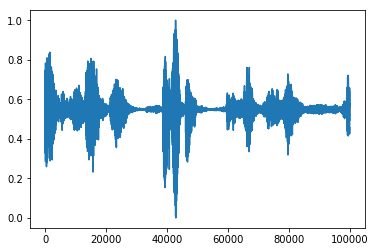

In [2715]:
plt.plot(sample[0].numpy())
#plt.plot(sample[1].numpy())

In [2717]:
ipd.Audio(sample[0].numpy() , rate = 16000)

In [2719]:
# Train / Test Split 
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42


dataset_size = len(v) # len of the voices dataset 
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed) # These will perform what is assigned to validation and what is 
                        #assigned to training
    np.random.shuffle(indices)
# grab indices 
train_indices, val_indices = indices[split:], indices[:split]


# Creating PT data samplers and loaders:

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


In [2720]:
torch.utils.data.dataloader.default_collate = torch.utils.data.dataloader.default_collate

In [2721]:
torch.utils.data.dataloader.default_collate = (lambda default_collate = torch.utils.data.dataloader.default_collate: lambda batch: batch if all(map(torch.is_tensor, batch)) and any([tensor.size() != batch[0].size() for tensor in batch]) else default_collate(batch))()

In [2722]:
train_loader = torch.utils.data.DataLoader(v, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(v, batch_size=batch_size,
                                                sampler=valid_sampler)

In [2723]:
batch = next(iter(train_loader))

In [2724]:
time_series , labels = batch

In [2725]:
time_series, labels 

((tensor([0.3497, 0.3482, 0.3467,  ..., 0.3545, 0.3562, 0.3570],
         dtype=torch.float64),
  tensor([0.4049, 0.4428, 0.4775,  ..., 0.4683, 0.4821, 0.4933],
         dtype=torch.float64),
  tensor([0.6101, 0.5885, 0.5313,  ..., 0.4309, 0.4401, 0.4498],
         dtype=torch.float64),
  tensor([0.6194, 0.6188, 0.6192,  ..., 0.5961, 0.5892, 0.5987],
         dtype=torch.float64)),
 (tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
  tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
  tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
  tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)))

In [2885]:
for i in labels:
    print(len(i))

117357
118877
97117
116557


In [2727]:
time_series

(tensor([0.3497, 0.3482, 0.3467,  ..., 0.3545, 0.3562, 0.3570],
        dtype=torch.float64),
 tensor([0.4049, 0.4428, 0.4775,  ..., 0.4683, 0.4821, 0.4933],
        dtype=torch.float64),
 tensor([0.6101, 0.5885, 0.5313,  ..., 0.4309, 0.4401, 0.4498],
        dtype=torch.float64),
 tensor([0.6194, 0.6188, 0.6192,  ..., 0.5961, 0.5892, 0.5987],
        dtype=torch.float64))

tensor([0.6101, 0.5885, 0.5313,  ..., 0.4309, 0.4401, 0.4498])

In [2737]:
new_time_series= torch.nn.utils.rnn.pad_sequence([torch.Tensor(t.float()) for t in batch[0]]).t()

In [2738]:
print(new_time_series.shape)
print(new_time_series)

torch.Size([4, 118877])
tensor([[0.3497, 0.3482, 0.3467,  ..., 0.0000, 0.0000, 0.0000],
        [0.4049, 0.4428, 0.4775,  ..., 0.4683, 0.4821, 0.4933],
        [0.6101, 0.5885, 0.5313,  ..., 0.0000, 0.0000, 0.0000],
        [0.6194, 0.6188, 0.6192,  ..., 0.0000, 0.0000, 0.0000]])


In [2739]:
# Now we have padded with more zeros at the end here.
new_labels = torch.nn.utils.rnn.pad_sequence([torch.Tensor(t.float()) for t in batch[1]], padding_value = 0).t()
new_labels.shape

torch.Size([4, 118877])

In [2740]:
new_time_series,new_labels

(tensor([[0.3497, 0.3482, 0.3467,  ..., 0.0000, 0.0000, 0.0000],
         [0.4049, 0.4428, 0.4775,  ..., 0.4683, 0.4821, 0.4933],
         [0.6101, 0.5885, 0.5313,  ..., 0.0000, 0.0000, 0.0000],
         [0.6194, 0.6188, 0.6192,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [2741]:
# add the feature dimension of 1 here 
new_time_series = new_time_series.unsqueeze(2)

In [2742]:
new_time_series.shape # shape should be torch.Size([4, max length , 1])

torch.Size([4, 118877, 1])

In [2744]:
new_labels = new_labels.unsqueeze(2)

In [2745]:
new_labels.shape # same shape as the time series input

torch.Size([4, 118877, 1])

In [ ]:
lengths = torch.Tensor([len(i) for i in time_series])
lengths = torch.sort(lengths, descending = True)[0]

In [2762]:
packed_time_series = torch.nn.utils.rnn.pack_padded_sequence(new_time_series, lengths, batch_first=True)
print(packed_time_series)

PackedSequence(data=tensor([[0.3497],
        [0.4049],
        [0.6101],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]]), batch_sizes=tensor([4, 4, 4,  ..., 1, 1, 1]))


In [2747]:
print(type(packed_time_series))

<class 'torch.nn.utils.rnn.PackedSequence'>


In [2763]:
lstm = torch.nn.LSTM(input_size = 1 , hidden_size=2, num_layers = 1 , batch_first=True)
#can change the hidden_size hyperparameter.
# We feed in the packed input timeseries
lstm_out , hidden  = lstm(packed_time_series.float())

In [2901]:
lstm_out

PackedSequence(data=tensor([[-0.0518,  0.0501],
        [-0.0565,  0.0436],
        [-0.0737,  0.0143],
        ...,
        [-0.0304,  0.1102],
        [-0.0304,  0.1102],
        [-0.0304,  0.1102]], grad_fn=<CatBackward>), batch_sizes=tensor([4, 4, 4,  ..., 1, 1, 1]))

In [2774]:
padded_output, output_lens = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

In [2902]:
print(padded_output.shape) # batch size , len with padddings , hidden state
print(output_lens) # same as original date




torch.Size([4, 118877, 2])
tensor([118877, 117357, 116557,  97117])


In [2895]:
padded_output.shape

torch.Size([4, 118877, 2])

In [2884]:
lstm_out[0].shape

torch.Size([449908, 2])

In [2916]:
# need to pass this to linear layer now. 
seq = l4.to_linear(padded_output)
print(nn.MSELoss()(seq[1,:117357], new_labels[1,117357]))
seq[1,:117357].shape

tensor(0.1694, grad_fn=<MseLossBackward>)


torch.Size([117357, 1])

In [2913]:
print(output_lens)

tensor([118877, 117357, 116557,  97117])


In [2917]:
seq.shape # This has the same dimensions as the input time series now. [Batch Size , Audio Len, 1 feature]

torch.Size([4, 118877, 1])

In [2882]:
# can use nn.sigmoid()


tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<SoftmaxBackward>)

In [2918]:
from torch import nn
from torch.autograd import Variable
class LSTMModel(nn.Module):
    def __init__(self, input_size , hidden_size , num_layers, output_dim = 1 , batch_size = 4):
        super(LSTMModel , self).__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.to_linear = nn.Linear(hidden_size , output_dim)
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))
    
    def forward(self, x , length):
        # Pack the padded sequence Here 
        packed = pack_padded_sequence(x)
        
        out , self.hidden = self.lstm(x) # Feed the packed sequence here 
        
        # pad_packed_sequence to reshape the output after the lstm 
        
        seq = self.to_linear(out)
        
        # Pass the entirety of the lstm output for the seq2seq predictions
        #y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return F.log_softmax(seq)
    
        
        

        

In [2797]:
l4 = LSTMModel(input_size = 1, hidden_size = 2, num_layers = 1)